In [70]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import tree 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets, linear_model, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format',lambda x: '%.4f' %x)
pd.options.mode.chained_assignment = None

train_data = pd.read_csv('data/trainingset.txt',header=None)
test_data = pd.read_csv('data/queries.txt',header=None)
#set column names for train_data
train_data.columns = ['id','age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome','output']
test_data.columns = ['id','age','job','marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome','output']

#assign the datatypes to the columns
train_data.age = train_data.age.astype('int64')
train_data.job = train_data.job.astype('category')
train_data.marital = train_data.marital.astype('category')
train_data.education = train_data.education.astype('category')
train_data.default = train_data.default.map({'yes':1,'no':0})
train_data.balance = train_data.balance.astype('float64')
train_data.housing = train_data.housing.map({'yes': 1, 'no': 0})
train_data.loan = train_data.loan.map({'yes': 1, 'no': 0})
train_data.contact = train_data.contact.map({'cellular': 0, 'telephone': 1, 'unknown': 2})
train_data.day = train_data.day.astype('int64')
train_data.month = train_data.month.astype('category')
train_data.duration = train_data.duration.astype('int64')
train_data.campaign = train_data.campaign.astype('int64')
train_data.pdays = train_data.pdays.astype('int64')
train_data.previous = train_data.previous.astype('int64')
train_data.poutcome = train_data.poutcome.map({'failure': 0, 'success': 1, 'unknown': 2})
train_data.output = train_data.output.map({'TypeA': 1, 'TypeB': 0})

#assign the same datatypes to the columns of the test_data
test_data.age = test_data.age.astype('int64')
test_data.job = test_data.job.astype('category')
test_data.marital = test_data.marital.astype('category')
test_data.education = test_data.education.astype('category')
test_data.default = test_data.default.map({'yes':1,'no':0})
test_data.balance = test_data.balance.astype('float64')
test_data.housing = test_data.housing.map({'yes': 1, 'no': 0})
test_data.loan = test_data.loan.map({'yes': 1, 'no': 0})
test_data.contact = test_data.contact.map({'cellular': 0, 'telephone': 1, 'unknown': 2})
test_data.day = test_data.day.astype('int64')
test_data.month = test_data.month.astype('category')
test_data.duration = test_data.duration.astype('int64')
test_data.campaign = test_data.campaign.astype('int64')
test_data.pdays = test_data.pdays.astype('int64')
test_data.previous = test_data.previous.astype('int64')
test_data.poutcome = test_data.poutcome.map({'failure': 0, 'success': 1, 'unknown': 2})
test_data.output = test_data.output.map({'TypeA': 1, 'TypeB': 0})

#convert the catagorical variables to dummy variables
train_data = pd.get_dummies(train_data, columns=['job','marital','education','default','housing','loan','contact','month','poutcome'],drop_first=True)
test_data = pd.get_dummies(test_data, columns=['job','marital','education','default','housing','loan','contact','month','poutcome'],drop_first=True)


In [71]:

#create a function that uses linear regression to predict the output column in test_data
#then write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
def predict(test_data):
    #split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','output'], axis=1), train_data['output'], test_size=0.35, random_state=4)
    #create a linear regression model
    regr = linear_model.LinearRegression()
    #fit the model to the training data
    regr.fit(X_train, y_train)
    #predict the output column in test_data
    y_pred = regr.predict(X_test)
    print(y_pred)
    #test the accuracy of the model
    print("accuracy score: ",accuracy_score(y_test, y_pred.round()))

    # variance score: 1 means perfect prediction
    print('Variance score: {}'.format(regr.score(X_test, y_test)))  

    #print out the error rates
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    #write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
    test_data['output'] = regr.predict(test_data.drop(['id','output'], axis=1)).round()
    #round the test_data['output'] to nearest 1 or 0
    test_data['output'] = test_data['output'].map({1:'TypeA', 0:'TypeB'})
    test_data.to_csv('testdata.txt', sep=',', header=True, index=False)
    #drop all the columns except id and output
    output_data = test_data[['id','output']]
    #write the predictions to a txt file
    output_data.to_csv('predictions.txt', sep=',', header=True, index=False)

    return test_data, output_data
test_data, output_data = predict(test_data)
output_data.describe()

accuracy score:  0.8966165413533834
Variance score: 0.18199210785877262
Mean Absolute Error: 0.1719665548561169
Mean Squared Error: 0.08473701104471518
Root Mean Squared Error: 0.2910962229997414


,id,output
count,2703,2703
unique,2703,2
top,TEST1,TypeA
freq,1,2625


In [72]:
#create a predict function that uses decision tree to predict the output column in test_data
#then write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
def predict_tree(test_data):
    #split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','output'], axis=1), train_data['output'], test_size=0.35, random_state=4)
    #create a decision tree model
    clf = tree.DecisionTreeClassifier()
    #fit the model to the training data
    clf = clf.fit(X_train, y_train)
    #predict the output column in test_data
    y_pred = clf.predict(X_test)
    #test the accuracy of the model
    print("accuracy score: ",accuracy_score(y_test, y_pred))

    # variance score: 1 means perfect prediction
    print('Variance score: {}'.format(clf.score(X_test, y_test)))  

    #print out the error rates
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    #write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
    test_data['output'] = clf.predict(test_data.drop(['id','output'], axis=1))
    #round the test_data['output'] to nearest 1 or 0
    test_data['output'] = test_data['output'].map({1:'TypeA', 0:'TypeB'})
    test_data.to_csv('testdata.txt', sep=',', header=True, index=False)
    #drop all the columns except id and output
    output_data = test_data[['id','output']]
    #write the predictions to a txt file
    output_data.to_csv('predictions.txt', sep=',', header=True, index=False)
    return test_data, output_data

#call the function predict()
test_data, output_data = predict_tree(test_data)
output_data.describe()

accuracy score:  0.8332941729323309
Variance score: 0.8332941729323309
Mean Absolute Error: 0.16670582706766918
Mean Squared Error: 0.16670582706766918
Root Mean Squared Error: 0.40829624914719603


,id,output
count,2703,2703
unique,2703,2
top,TEST1,TypeA
freq,1,2378


In [73]:
#create a predict function that uses random forest to predict the output column in test_data
#then write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
def predict_forest(test_data):
    #split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','output'], axis=1), train_data['output'], test_size=0.35, random_state=4)
    #create a random forest model
    clf = RandomForestClassifier(n_estimators=100)
    #fit the model to the training data
    clf = clf.fit(X_train, y_train)
    #predict the output column in test_data
    y_pred = clf.predict(X_test)
    #test the accuracy of the model
    print("accuracy score: ",accuracy_score(y_test, y_pred))

    # variance score: 1 means perfect prediction
    print('Variance score: {}'.format(clf.score(X_test, y_test)))  

    #print out the error rates
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    #write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
    test_data['output'] = clf.predict(test_data.drop(['id','output'], axis=1))
    #round the test_data['output'] to nearest 1 or 0
    test_data['output'] = test_data['output'].map({1:'TypeA', 0:'TypeB'})
    test_data.to_csv('testdata.txt', sep=',', header=True, index=False)
    #drop all the columns except id and output
    output_data = test_data[['id','output']]
    #write the predictions to a txt file
    output_data.to_csv('predictions.txt', sep=',', header=True, index=False)
    return test_data, output_data
#call the function predict_forest()
test_data, output_data = predict_forest(test_data)
output_data.describe()



accuracy score:  0.8966165413533834
Variance score: 0.8966165413533834
Mean Absolute Error: 0.10338345864661654
Mean Squared Error: 0.10338345864661654
Root Mean Squared Error: 0.32153298220651727


,id,output
count,2703,2703
unique,2703,2
top,TEST1,TypeA
freq,1,2610


In [74]:
#create a predict function that uses Naive Bayes to predict the output column in test_data
#then write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
def predict_nb(test_data):
    #split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','output'], axis=1), train_data['output'], test_size=0.35, random_state=4)
    #create a naive bayes model
    clf = GaussianNB()
    #fit the model to the training data
    clf = clf.fit(X_train, y_train)
    #predict the output column in test_data
    y_pred = clf.predict(X_test)
    #test the accuracy of the model
    print("accuracy score: ",accuracy_score(y_test, y_pred))

    # variance score: 1 means perfect prediction
    print('Variance score: {}'.format(clf.score(X_test, y_test)))  

    #print out the error rates
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    #write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
    test_data['output'] = clf.predict(test_data.drop(['id','output'], axis=1))
    #round the test_data['output'] to nearest 1 or 0
    test_data['output'] = test_data['output'].map({1:'TypeA', 0:'TypeB'})
    test_data.to_csv('testdata.txt', sep=',', header=True, index=False)
    #drop all the columns except id and output
    output_data = test_data[['id','output']]
    #write the predictions to a txt file
    output_data.to_csv('predictions.txt', sep=',', header=True, index=False)
    return test_data, output_data

#call the function predict_nb()
test_data, output_data = predict_nb(test_data)
output_data.describe()

accuracy score:  0.8612546992481203
Variance score: 0.8612546992481203
Mean Absolute Error: 0.13874530075187969
Mean Squared Error: 0.13874530075187969
Root Mean Squared Error: 0.3724853027327114


,id,output
count,2703,2703
unique,2703,2
top,TEST1,TypeA
freq,1,2385


In [75]:
#create a predict function that uses KNN to predict the output column in test_data
#then write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
def predict_knn(test_data):
    #split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','output'], axis=1), train_data['output'], test_size=0.35, random_state=4)
    sScalar = StandardScaler()
    X_train = sScalar.fit_transform(X_train)
    X_test = sScalar.transform(X_test)
    
    #create a KNN model
    clf = KNeighborsClassifier(n_neighbors=7)
    #fit the model to the training data
    clf = clf.fit(X_train, y_train)
    #predict the output column in test_data
    y_pred = clf.predict(X_test)
    #test the accuracy of the model
    print("accuracy score: ",accuracy_score(y_test, y_pred))

    # variance score: 1 means perfect prediction
    print('Variance score: {}'.format(clf.score(X_test, y_test)))  

    #print out the error rates
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    #write the predictions to a txt file using the layout <id>,<output> where <id> is the id and <output> is either TypeA or TypeB
    test_data['output'] = clf.predict(test_data.drop(['id','output'], axis=1))
    #round the test_data['output'] to nearest 1 or 0
    test_data['output'] = test_data['output'].map({1:'TypeA', 0:'TypeB'})
    test_data.to_csv('testdata.txt', sep=',', header=True, index=False)
    #drop all the columns except id and output
    output_data = test_data[['id','output']]
    #write the predictions to a txt file
    output_data.to_csv('predictions.txt', sep=',', header=True, index=False)
    return test_data, output_data

#call the function predict_knn()
test_data, output_data = predict_knn(test_data)
output_data.describe()



accuracy score:  0.8813439849624061
Variance score: 0.8813439849624061
Mean Absolute Error: 0.11865601503759399
Mean Squared Error: 0.11865601503759399
Root Mean Squared Error: 0.34446482409325047


,id,output
count,2703,2703
unique,2703,2
top,TEST1,TypeA
freq,1,2652


KNN with k =  1 :  0.8241306390977443
KNN with k =  2 :  0.7651550751879699
KNN with k =  3 :  0.8686560150375939
KNN with k =  4 :  0.8512687969924813
KNN with k =  5 :  0.878171992481203
KNN with k =  6 :  0.8745300751879699
KNN with k =  7 :  0.8813439849624061
KNN with k =  8 :  0.8793468045112782
KNN with k =  9 :  0.8818139097744361
KNN with k =  10 :  0.8806390977443609
KNN with k =  11 :  0.8826362781954887
KNN with k =  12 :  0.8820488721804511
KNN with k =  13 :  0.8816964285714286
KNN with k =  14 :  0.8818139097744361


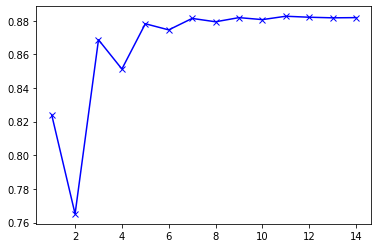

In [76]:
#create a function to cross validate the model
def cross_validate(train_data):
    #split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(train_data.drop(['id','output'], axis=1), train_data['output'], test_size=0.35, random_state=4)
    #create a list of the KNN model with different values of K
    K = range(1,15)
    #create an empty list to store the scores of the KNN model with different values of K
    scores = []
    #loop through each value of K
    for k in K:
        #create a KNN model
        clf = KNeighborsClassifier(n_neighbors=k)
        #fit the model to the training data
        clf = clf.fit(X_train, y_train)
        #append the scores of the model to scores
        scores.append(clf.score(X_test, y_test))
        print("KNN with k = ",k,": ",scores[k-1])
    #plot the scores of the KNN model with different values of K
    plt.figure()
    plt.plot(K, scores, 'bx-')
cross_validate(train_data)